In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve,log_loss,average_precision_score
from sklearn.metrics import f1_score
import random
import gc
from catboost import CatBoostClassifier
%matplotlib inline

In [3]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = pd.read_csv('df_sortprob_23_no_test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [5]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print("'"+nm+"'",', ',end='')        

In [6]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [7]:
def group_ag(main_columns, uids, train_df, test_df, aggregations=['mean'],
              fillna = True):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'__'+col+'_'+agg_type
                #拼接训练集和测试集
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])  
                #求AGG
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # 取出目标列作为索引
                temp_df.index = list(temp_df[col])
                # 生成map对应的字典
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)  
                    
                print("'"+new_col_name+"'",', ',end='')
#group_ag(['conam'],['cano'],df,df_test,['mean','std'])
#df['conam_cano_std'].value_counts()

In [8]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [9]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [10]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print("'"+nm+"'",', ',end='')
   

In [11]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
#big_top_value_cols.remove('iterm')
#big_top_value_cols.remove('hcefg')
#big_top_value_cols.remove('contp')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [12]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [13]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [14]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [15]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
import copy
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')
(1521787, 19)


In [16]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.figure(figsize=(8,8))
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

## 從這裡開始

In [17]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

19
18
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')


In [18]:
cano_col=['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
        'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd',  'loctm_hour', 'loctm_min', 'loctm_s']
##新特徵

encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)
for col in cano_col:
    encode_CB('cano',col,df,df_test)
    


'bacno_cano' , 'mcc_mchno' , 'stocn_scity' , 'stscd_csmcu' , 'cano_mcc_mchno' , 'cano_acqic' , 'cano_conam' , 'cano_csmcu' , 'cano_ecfg' , 'cano_etymd' , 'cano_locdt' , 'cano_loctm' , 'cano_mcc' , 'cano_mchno' , 'cano_scity' , 'cano_stocn' , 'cano_stscd' , 'cano_loctm_hour' , 'cano_loctm_min' , 'cano_loctm_s' , 

In [19]:
count_features =['acqic', 'bacno', 'cano', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   

encode_FE(df,df_test,count_features)
cf =  [  'bacno_FE' , 'cano_FE'  ,
      'mcc_FE' , 'mchno_FE' , 
      'mcc_mchno_FE' , ]

'acqic_FE' , 'bacno_FE' , 'cano_FE' , 'conam_FE' , 'csmcu_FE' , 'ecfg_FE' , 'etymd_FE' , 'mcc_FE' , 'mchno_FE' , 'scity_FE' , 'stocn_FE' , 'stscd_FE' , 'loctm_hour_FE' , 'stocn_scity_FE' , 'mcc_mchno_FE' , 

In [20]:
count_features =['cano_locdt']

encode_FE(df,df_test,count_features)
cf2 =  [  'cano_locdt_FE'  ]

'cano_locdt_FE' , 

In [21]:
col_test =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']

re_num_2 =['ecfg']

new = set(col_test)-set(re_num_2)
for col in list(new):      
    group_ag([col],['cano_mcc'],df,df_test,['mean','std'])  
for col in col_test:      
    group_ag([col],['cano'],df,df_test,['mean','std'])
for col in list(new):      
    group_ag([col],['cano_locdt'],df,df_test,['mean','std'])  

'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' , 'mcc__cano_mcc_mean' , 'mcc__cano_mcc_std' , 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'etymd__cano_mcc_mean' , 'etymd__cano_mcc_std' , 'csmcu__cano_mcc_mean' , 'csmcu__cano_mcc_std' , 'acqic__cano_mcc_mean' , 'acqic__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'stocn_scity__cano_mcc_mean' , 'stocn_scity__cano_mcc_std' , 'mchno__cano_mcc_mean' , 'mchno__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'mcc_mchno__cano_mcc_mean' , 'mcc_mchno__cano_mcc_std' , 'acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 's

In [25]:
gf_mcc=[ 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' ,  ]

In [26]:
gf =['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]
re_gf =[ 'etymd__cano_std', 'stscd__cano_std' , ]
gf = set(gf) -set(re_gf)

In [27]:
gf2=['csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' , ]

In [25]:
model1_features =['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+cf+cf2+list(gf)+list(gf2)+list(gf_mcc)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)Z
print(X_train.shape[1])
print(X_train.columns)
#show_cor(df[model1_features])

77
Index(['acqic', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc_FE', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__cano_locdt_std', 'mcc_mchno__can

In [26]:
# 将概率最大的20%作为验证集
df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
df_train_2 = df.iloc[:int(0.8 * len(df)), ]

In [28]:
import time
predictions = np.zeros(len(X_test))

NameError: name 'X_test' is not defined

In [ ]:
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
    
    trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
    val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
    Dtrain_df = xgb.DMatrix(train_df,missing=-100)
    Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
    DX_test = xgb.DMatrix(X_test,missing=-100)
    watchlist = [(trn_data,'train'),(val_data,'val')]
    model = xgb.train(params,
                    trn_data,
                    num_boost_round= 10000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
    pred = model.predict(Dvalid_df)   
    
    
    pred_file_path = 'compare_xgb.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))   
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
  
    print('_'*100)
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

last  auc =  0.9956298777849382


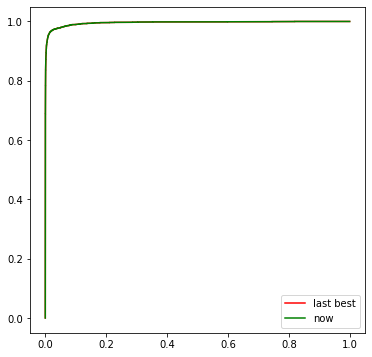

In [38]:
pred_file_path = 'compare_xgb.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.figure(figsize=(6,6))
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


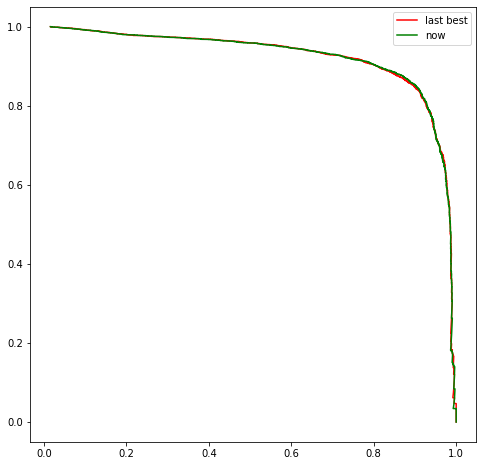

In [40]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

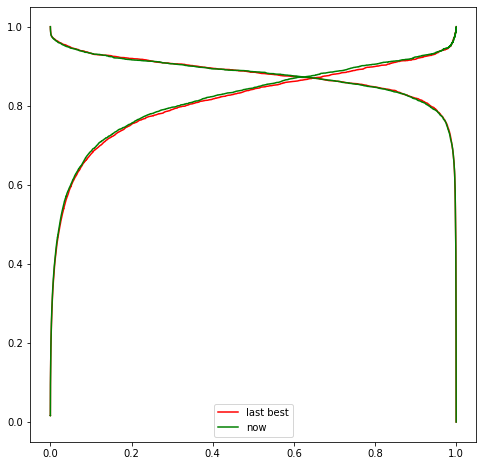

In [41]:
plt.figure(figsize=(8,8))
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [76]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare_xgb.csv',index=None)

save  file...


In [42]:
precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)

In [ ]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

In [28]:
seed = 1121
np.random.seed(seed)
random.seed(seed)

In [37]:
 params = {'max_depth': 47,
                      
              'learning_rate':0.02,
              
              'colsample_bytree':0.4,
              'subsample':0.8,
             
              'scale_pos_weight':73.76231884057971,
              'max_delta_step ':0,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
               # USE CPU
               #'nthread' :1,
              #tree_method='hist'
               # USE GPU
              'gpu_id':'4',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss',
           'gamma': 0.15626466439591735,
           'min_child_weight':1.5233399970515784, 
            'reg_alpha':4.989195734088519,
              'reg_lambda':4.292050649851185,
             #'seed':seed,
            # 'random_state ':seed,
             # 'shuffle':False,
             }

In [43]:
 params = {'max_depth': 47,
                      
              'learning_rate':0.02,
              
              'colsample_bytree':0.6845594711468237,
              'subsample': 0.6270356606257379,
             
              'scale_pos_weight':73.76231884057971,
              'max_delta_step ':0,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
               # USE CPU
               #'nthread' :1,
              #tree_method='hist'
               # USE GPU
              'gpu_id':'4',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss',
           'gamma': 0.5216569924939722,
           'min_child_weight':2.8278927399386085, 
            'reg_alpha':0.3902447945616852,
              'reg_lambda':0.33225047761472043,
             #'seed':seed,
            # 'random_state ':seed,
             # 'shuffle':False,
             }

In [30]:
from bayes_opt import BayesianOptimization

In [46]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(gamma,min_child_weight,subsample,colsample_bytree,reg_alpha,reg_lambda):
    params = {'max_depth': 47,
              'gamma': gamma,             
              'scale_pos_weight':73.76231884057971,
              'learning_rate':0.02,
              'min_child_weight':int(min_child_weight), 
              'colsample_bytree':colsample_bytree,
              'subsample':subsample,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda,            
              'missing' : -100,
              'objective' :'binary:logistic',
              'gpu_id':'6',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss'}
    dtrain = xgb.DMatrix(X_train, Y_train, missing=-100)   
    cv_result = xgb.cv(params, dtrain, num_boost_round=1, early_stopping_rounds=200, nfold=3,seed=seed)
    print(cv_result)
    return cv_result['test-logloss-mean'].iloc[-1]

In [47]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {#'max_depth': (40, 50),
                                             'gamma': (0, 1),                                            
                                             'min_child_weight':(1,6),
                                            'subsample':(0.6,1),
                                            'colsample_bytree':(0.6,0.9),
                                            'reg_alpha':(0.05,3),
                                            'reg_lambda':(0.05,3),                                            
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   | colsam... |   gamma   | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674147           0.000017           0.674249          0.000025
|  1        |  0.6742   |  0.8803   |  0.2428   |  4.551    |  2.903    |  1.108    |  0.6267   |
   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.673979           0.000002           0.674107          0.000006
|  2        |  0.6741   |  0.679    |  0.3009   |  1.949    |  2.925    |  0.1869   |  0.6508   |
   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674076           0.000028           0.674205          0.000032
|  3        |  0.6742   |  0.6963   |  0.6749   |  1.127    |  0.4162   |  2.138    |  0.8478   |
   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674378           0.000022           0.674467          0.000018
|  4        |  0.6745   |  0.7059   |  0.4007   |  1.485    |  2.406    |  2.931  

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674228            0.00001           0.674345          0.000019
|  9        |  0.6743   |  0.6482   |  0.3922   |  5.967    |  0.07883  |  2.891    |  0.9639   |


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.673533           0.000003           0.673738      8.164966e-07
|  10       |  0.6737   |  0.8022   |  0.2108   |  1.023    |  0.1583   |  0.1235   |  0.945    |


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674298           0.000026           0.674405          0.000024
|  11       |  0.6744   |  0.8524   |  0.5173   |  5.883    |  2.716    |  2.977    |  0.8665   |


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.674336           0.000023           0.674444          0.000026
|  12       |  0.6744   |  0.657    |  0.3574   |  5.887    |  2.931    |  2.817    |  0.9587   |


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.67408           0.000009           0.674181          0.000023
|  13       |  0.6742   |  0.6756   |  0.972    |  5.87     |  2.99     |  0.09778  |  0.6098   |


In [48]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

{'colsample_bytree': 0.7059116281776322, 'gamma': 0.40069320193725366, 'min_child_weight': 1.4846766672564873, 'reg_alpha': 2.4055125187194095, 'reg_lambda': 2.9307957288073614, 'subsample': 0.6136160376363944}


## train start!

(1521787, 77)
train feature  Index(['acqic', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc_FE', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__cano_l

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.673836	val-logloss:0.674095
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.07745	val-logloss:0.087282
[200]	train-logloss:0.016709	val-logloss:0.029639
[300]	train-logloss:0.007316	val-logloss:0.022434
[400]	train-logloss:0.004985	val-logloss:0.021603
[500]	train-logloss:0.003959	val-logloss:0.021597
[600]	train-logloss:0.003354	val-logloss:0.021749
Stopping. Best iteration:
[466]	train-logloss:0.004244	val-logloss:0.021555

  confusion_matrix = 
 [[498863   1408]
 [  2100   4964]]


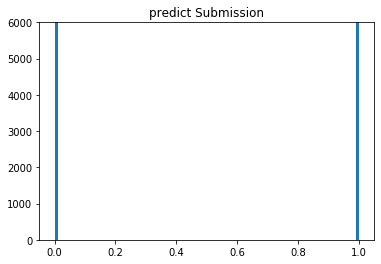

____________________________________________________________________________________________________
Fold 1


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.673826	val-logloss:0.674077
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.077507	val-logloss:0.087285
[200]	train-logloss:0.016761	val-logloss:0.030006
[300]	train-logloss:0.007326	val-logloss:0.02303
[400]	train-logloss:0.00498	val-logloss:0.022409
[500]	train-logloss:0.003976	val-logloss:0.022464
[600]	train-logloss:0.003362	val-logloss:0.022633
Stopping. Best iteration:
[436]	train-logloss:0.004545	val-logloss:0.022387

  confusion_matrix = 
 [[498961   1387]
 [  2034   4796]]


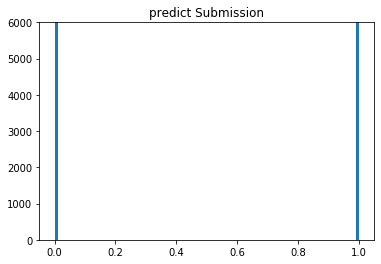

____________________________________________________________________________________________________
Fold 2


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.673839	val-logloss:0.674072
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.077773	val-logloss:0.086915
[200]	train-logloss:0.016954	val-logloss:0.0293
[300]	train-logloss:0.007465	val-logloss:0.022109
[400]	train-logloss:0.005111	val-logloss:0.021341
[500]	train-logloss:0.004065	val-logloss:0.021295
[600]	train-logloss:0.003431	val-logloss:0.021423
Stopping. Best iteration:
[450]	train-logloss:0.004518	val-logloss:0.02127

  confusion_matrix = 
 [[499334   1479]
 [  1831   4630]]


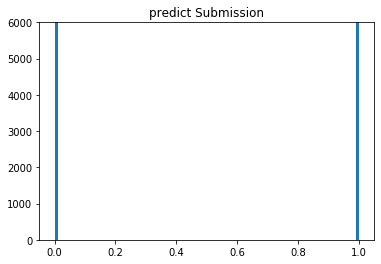

last oof  auc =  0.9918154378797385
oof  auc =  0.9913422367837234
last oof  f1 =  0.7410148779215617
oof  f1 =  0.7375893795330479
last oof  average_precision =  0.8051341424188303
oof  average_precision =  0.800126163714194
confusion_matrix =
[[1497158    4274]
 [   5965   14390]]


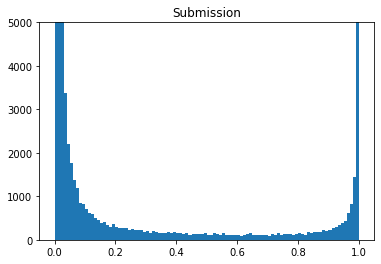

It cost 313.056703 sec


In [44]:
    tStart = time.time()#計時開始   
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    ##folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    print(X_train.shape)
    print('train feature ',X_train.columns)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))       
             
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        trn_data = xgb.DMatrix(train_df, label=y_train_df)
        val_data = xgb.DMatrix(valid_df, label=y_valid_df) 
        Dtrain_df = xgb.DMatrix(train_df)
        Dvalid_df = xgb.DMatrix(valid_df)
        DX_test = xgb.DMatrix(X_test)
        watchlist = [(trn_data,'train'),(val_data,'val')]        
       
        
        clf = xgb.train(params,
                    trn_data,
                    num_boost_round= 100000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
        pred = clf.predict(Dvalid_df) 
        
        oof[val_idx] = pred
        #print(pred[0])
       
    
        #print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        #print( "  f1 = ", f1_score(y_valid_df, y_pre))
        print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)
        
        predictions += clf.predict(DX_test) / splits
        del trn_data, val_data
        gc.collect()
   
        prediction = [int(item>threshold) for  item in predictions]    
 
        plt.hist(y_pre,bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    pred_file_path = 'compare_fold_xgb.csv'
    last_oof = np.array(pd.read_csv(pred_file_path))  
    #print( "avg  auc = ", auc_avg/ splits )
    #print( "avg  f1 = ", f1_avg/ splits)
    print( "last oof  auc = ", roc_auc_score(Y_train, last_oof) )
    print( "oof  auc = ", roc_auc_score(Y_train, oof) )  
    last_oof_threshold = [int(item>0.5) for  item in last_oof] 
    oof_threshold = [int(item>0.5) for  item in oof]
    print( "last oof  f1 = ", f1_score(Y_train, last_oof_threshold))
    print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
    print( "last oof  average_precision = ",average_precision_score(Y_train,last_oof))
    print( "oof  average_precision = ",average_precision_score(Y_train,oof))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train, oof_threshold))
    if(roc_auc_score(Y_train, last_oof)<roc_auc_score(Y_train, oof)):
        print("auc improve------------------------------------")
    if(f1_score(Y_train, last_oof_threshold)<f1_score(Y_train, oof_threshold)):
        print("f1 improve------------------------------------")
    if(average_precision_score(Y_train,last_oof)<average_precision_score(Y_train,oof)):
        print('ap improve-----------------------------------')
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()  
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


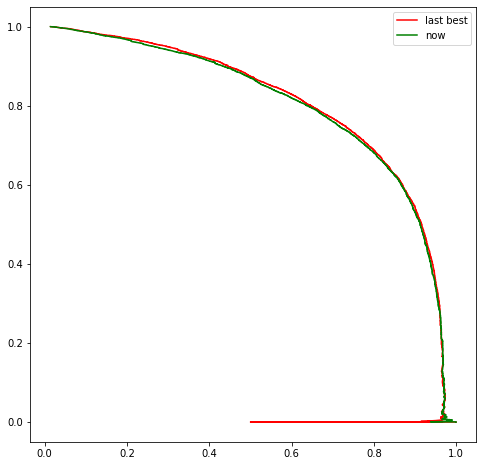

In [45]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
pr,re,t = precision_recall_curve(Y_train,oof)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 


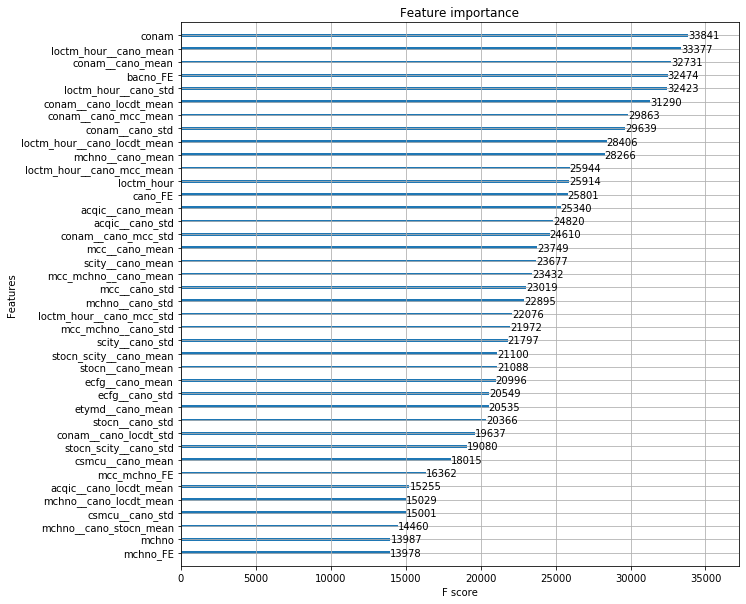

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(booster=clf,max_num_features = 40, ax=ax)
plt.show()

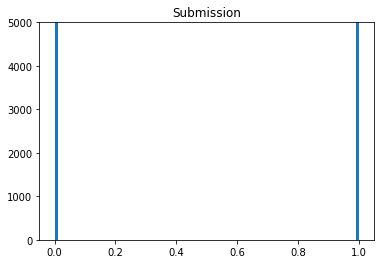

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 7509


In [66]:
# 结果保存
plt.hist(prediction,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = prediction
sampleSubmission.to_csv('submission_test_xgb.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])


In [82]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':oof})
last_pred.to_csv('compare_fold_xgb.csv',index=None)

save  file...
done here
